In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [128]:
test = pd.read_csv("data/test.csv.gz").drop(['record_date'], axis=1)
test['record_delay'] = np.abs(test['record_delay'])
test.head()

,merchant_id,latitude,longitude,real_transaction_dttm,record_delay,is_in_area
0,361,56.827622,60.581082,75631.0,64.0,1
1,361,55.750347,37.623851,43687.0,295.0,1
2,361,55.750347,37.623851,43747.0,307.0,1
3,361,55.750347,37.623851,43747.0,456.0,1
4,361,55.750347,37.623511,41004.0,352.0,1


In [129]:
train = pd.read_csv("data/train.csv.gz").drop(['record_date'], axis=1)
train['dist'] = np.round(train['dist'])
train['record_delay'] = np.abs(train['record_delay'])
train.head()

,merchant_id,latitude,longitude,real_transaction_dttm,record_delay,latitude_origin,longitude_origin,dist,is_in_area
0,178,0.000000,0.000000,34487.0,251.0,55.055553,82.911833,9555245.0,0
1,178,55.055996,82.912991,64190.0,274.0,55.055553,82.911833,89.0,1
2,178,0.000000,0.000000,34487.0,205.0,55.055553,82.911833,9555245.0,0
3,178,55.056034,82.912734,64190.0,409.0,55.055553,82.911833,79.0,1
4,178,55.056034,82.912734,64190.0,273.0,55.055553,82.911833,79.0,1


In [130]:
train.shape[0], train[train.duplicated(subset=['merchant_id', 'latitude', 'longitude']) == False].shape[0]
# в два раза можно уменьшить датасет убрав дубли!

(166912, 87088)

In [131]:
# Сортируем чтобы первыми были лучшие данные, это для убирания дублей полезно!
train.sort_values(['dist','record_delay'], inplace=True)
# Убираем дубли
train = train[train.duplicated(subset=['merchant_id', 'latitude', 'longitude']) == False]
train = train[train.duplicated(subset=['merchant_id', 'real_transaction_dttm']) == False]

In [132]:
test.sort_values(['is_in_area'], ascending=False, inplace=True)
test.sort_values(['record_delay'], inplace=True)

print(test.shape[0])
test = test[test.duplicated(['merchant_id', 'latitude', 'longitude']) == False]
test = test[test.duplicated(['merchant_id', 'real_transaction_dttm']) == False]
print(test.shape[0])

82441
44001


In [133]:
X = train.drop(['dist',      'latitude_origin', 'longitude_origin'], axis=1)
y = train['dist']
print(X.dtypes)
print(X.shape)
X.head()

merchant_id                int64
latitude                 float64
longitude                float64
real_transaction_dttm    float64
record_delay             float64
is_in_area                 int64
dtype: object
(85524, 6)


,merchant_id,latitude,longitude,real_transaction_dttm,record_delay,is_in_area
36500,228992,55.672829,37.484667,39956.0,2.0,1
34600,206828,59.984818,30.344084,81656.0,5.0,1
37729,246118,54.994987,82.965875,73778.0,7.0,1
5796,41902,59.956250,30.244389,64044.0,8.0,1
139238,679552,55.823292,37.497800,76750.0,9.0,1


In [134]:
y.head()

36500     0.0
34600     0.0
37729     0.0
5796      0.0
139238    0.0
Name: dist, dtype: float64

In [135]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

def test_clf(clf, X, y):
    rs=ShuffleSplit(n_splits=5, test_size=.25)
    scores = cross_val_score(clf, X, y, cv=rs, scoring='r2')
    print("R2: {} (+/- {})".format(scores.mean(), scores.std() * 2))

def findXgbParams(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = xgb.XGBRegressor()
    parameter_grid = {
        'n_estimators': [200],
        'learning_rate': [0.2],
        'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
        'max_depth': [4, 6, 8, 10]
    }
    grid_search = GridSearchCV(clf, param_grid=parameter_grid, cv=StratifiedKFold(5), scoring='r2')
    grid_search.fit(X_train, y_train)
    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))

In [136]:
%time test_clf(xgb.XGBRegressor(), X, y) # даже без оригинального lat/lon он весьма правильно предсказал? 0.93

R2: 0.9335037297105732 (+/- 0.005838719898078748)
CPU times: user 18.5 s, sys: 622 ms, total: 19.1 s
Wall time: 7.02 s


In [21]:
%time findXgbParams(X, y)

/usr/local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of 

Best score: 0.9819397572097128
Best parameters: {'learning_rate': 0.2, 'colsample_bytree': 1.0, 'max_depth': 10, 'n_estimators': 200}
CPU times: user 34min 2s, sys: 53.8 s, total: 34min 55s
Wall time: 20min 3s


In [137]:
xgb_params = {'learning_rate': 0.2, 'colsample_bytree': 1.0, 'max_depth': 10, 'n_estimators': 200}
xgb_clf = xgb.XGBRegressor(**xgb_params)

In [138]:
%time xgb_clf.fit(X, y)

CPU times: user 30.9 s, sys: 955 ms, total: 31.9 s
Wall time: 11.6 s


XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1.0,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=200, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [139]:
for f, imp in zip(X.columns, xgb_clf.feature_importances_):
    print(f, imp)

merchant_id 0.328128
latitude 0.213615
longitude 0.190651
real_transaction_dttm 0.156225
record_delay 0.110174
is_in_area 0.00120756


In [140]:
pred_dist = xgb_clf.predict(test)
pred_dist

array([ 2517926.        ,    45041.375     ,  4353273.        , ...,
         477838.4375    ,    11829.50488281,   361776.59375   ], dtype=float32)

In [141]:
test['dist'] = np.abs(np.round(pred_dist))
test['dist'].describe()

count       44001.00
mean       643402.75
std       1680239.50
min             2.00
25%         30761.00
50%         77056.00
75%        284730.00
max      14082806.00
Name: dist, dtype: float64

In [142]:
train['dist'].describe()

count    8.552400e+04
mean     5.986353e+05
std      1.678553e+06
min      0.000000e+00
25%      1.708000e+03
50%      9.051000e+03
75%      4.450050e+04
max      1.699301e+07
Name: dist, dtype: float64

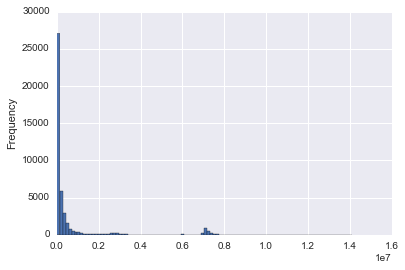

In [143]:
test['dist'].plot(kind='hist',bins=100) # Повторили распределение тестовой выборки. Только еще неизвестно, хорошо это или плохо.

In [146]:
test.to_csv("data/test_with_dist_without_dubs.csv.gz", compression='gzip', index=False)

In [145]:
train.to_csv("data/train_without_dubs.csv.gz", compression='gzip', index=False)